<div style="width: 100%; margin: 0 auto;">
    <a href="https://github.com/e10101/learning-operations-research">
        <img src="../assets/banner.svg" alt="Learning Operations Research" style="width: 100%; height: auto; display: block;">
    </a>
</div>

# Minimum-Cost Network Flow Problems
---

[![Github](../assets/badges/github.svg)](https://github.com/e10101/learning-operations-research)


## Graphical Representation

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Create a directed graph
G = nx.DiGraph()

In [3]:
# Add nodes
NODES = ['S', 'T1', 'T2', 'T3', 'T4', 'D']
for node in NODES:
    G.add_node(node)

In [4]:
# Add edges
EDGES = [
    ('S', 'T1'),
    ('S', 'T2'),
    ('T1', 'T2'),
    ('T1', 'T3'),
    ('T1', 'T4'),
    ('T2', 'T4'),
    ('T3', 'T4'),
    ('T3', 'D'),
    ('T4', 'D'),
]
for edge in EDGES:
    G.add_edge(*edge)

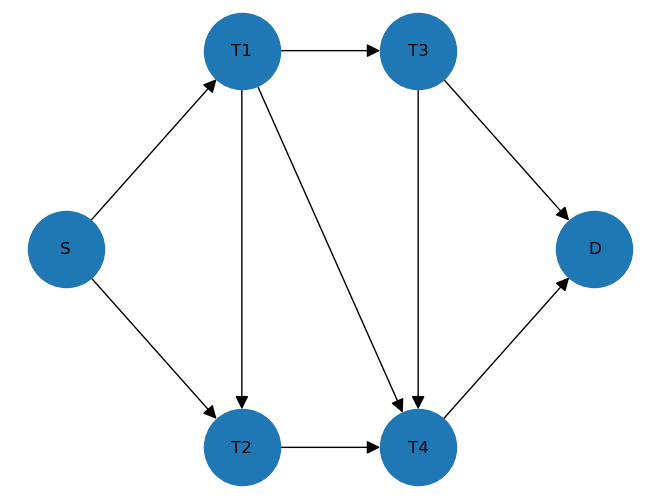

In [5]:
# Draw graph
NODE_POS = {
    'S': (0, 0),
    'T1': (1, 0.5),
    'T2': (1, -0.5),
    'T3': (2, 0.5),
    'T4': (2, -0.5),
    'D': (3, 0)
}
nx.draw(G, pos=NODE_POS, with_labels=True, node_size=3000, arrowsize=20)

In [6]:
# Add capacity and cost

CAPACITY = [
    100,
    80,
    40,
    30,
    50,
    90,
    20,
    120,
    60,
]
COST = [
    150,
    120,
    90,
    105,
    100,
    130,
    160,
    130,
    160,
]

for i in range(len(EDGES)):
    edge = EDGES[i]
    G.edges[edge]['capacity'] = CAPACITY[i]
    G.edges[edge]['cost'] = COST[i]

In [7]:
for edge in EDGES:
    print(f"edge: {edge}, with capacity: {G.edges[edge]['capacity']} and cost: {G.edges[edge]['cost']}")

edge: ('S', 'T1'), with capacity: 100 and cost: 150
edge: ('S', 'T2'), with capacity: 80 and cost: 120
edge: ('T1', 'T2'), with capacity: 40 and cost: 90
edge: ('T1', 'T3'), with capacity: 30 and cost: 105
edge: ('T1', 'T4'), with capacity: 50 and cost: 100
edge: ('T2', 'T4'), with capacity: 90 and cost: 130
edge: ('T3', 'T4'), with capacity: 20 and cost: 160
edge: ('T3', 'D'), with capacity: 120 and cost: 130
edge: ('T4', 'D'), with capacity: 60 and cost: 160


{('S', 'T1'): Text(0.5, 0.25, 'cap: 100, cost: 150'),
 ('S', 'T2'): Text(0.5, -0.25, 'cap: 80, cost: 120'),
 ('T1', 'T2'): Text(1.0, 0.0, 'cap: 40, cost: 90'),
 ('T1', 'T3'): Text(1.5, 0.5, 'cap: 30, cost: 105'),
 ('T1', 'T4'): Text(1.5, 0.0, 'cap: 50, cost: 100'),
 ('T2', 'T4'): Text(1.5, -0.5, 'cap: 90, cost: 130'),
 ('T3', 'T4'): Text(2.0, 0.0, 'cap: 20, cost: 160'),
 ('T3', 'D'): Text(2.5, 0.25, 'cap: 120, cost: 130'),
 ('T4', 'D'): Text(2.5, -0.25, 'cap: 60, cost: 160')}

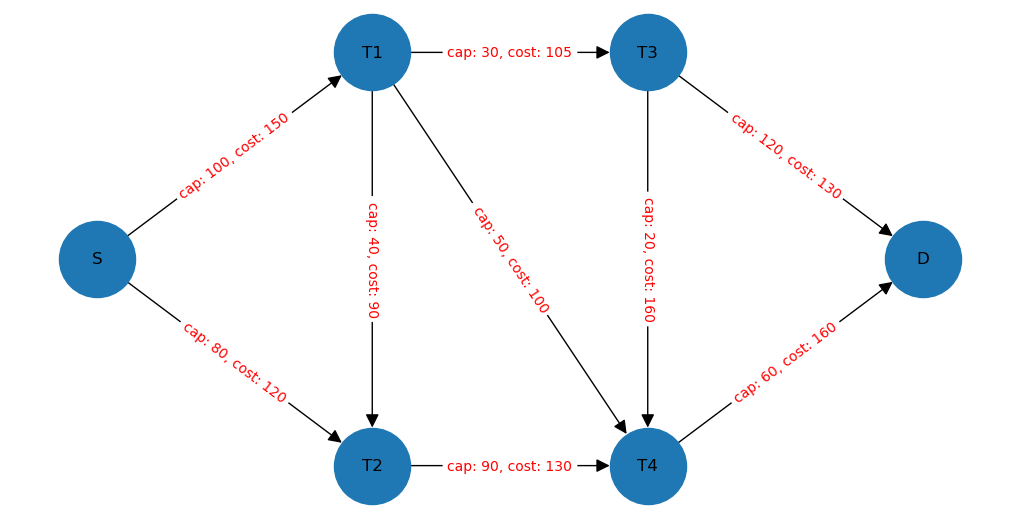

In [8]:
# Draw Graph with edge labels

plt.figure(figsize=(10, 5))

nx.draw(G, pos=NODE_POS, with_labels=True, node_size=3000, arrowsize=20)

capacity_labels = nx.get_edge_attributes(G, 'capacity')
cost_labels = nx.get_edge_attributes(G, 'cost')

edge_labels = {}
for edge, cap in capacity_labels.items():
    if edge in cost_labels:
        edge_labels[edge] = f'cap: {cap}, cost: {cost_labels[edge]}'
        
nx.draw_networkx_edge_labels(G, pos=NODE_POS, edge_labels=edge_labels, font_color='red')

## Solving with Gurobi

TODO